In [1]:
import h5py
import zipfile
import imageio
import os

In [2]:
%%time

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = './celeba_dataset/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('./img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
Wall time: 5min 13s


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with h5py.File('./celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
    for group in file_object:
        print(group)
        pass

img_align_celeba


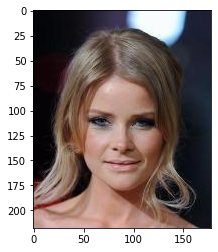

In [6]:
with h5py.File('./celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
    dataset = file_object['img_align_celeba']
    image = np.array(dataset['9.jpg'])
    plt.imshow(image, interpolation='none')
    pass

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [16]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index) + '.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(np.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    pass

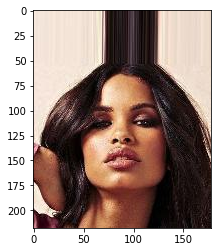

In [18]:
celeba_dataset = CelebADataset('./celeba_dataset/celeba_aligned_small.h5py')
celeba_dataset.plot_image(15369)

In [19]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [22]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [54]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(218*178*3),

            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()

        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim = (0), figsize=(16, 8), alpha=0.1, marker = '.', grid=True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
        pass

In [25]:
%%time

D = Discriminator().cuda(0)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor.cuda(0), torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)).cuda(0), torch.cuda.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
Wall time: 4min 21s


In [43]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # nn.Linear(1, 200),
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218,178,3))
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)

        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim = (0), figsize=(16, 8), alpha=0.1, marker = '.', grid=True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
        pass

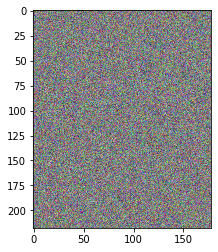

In [28]:
G = Generator().cuda(0)

output = G.forward(generate_random_seed(100).cuda(0))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [48]:
%%time

D = Discriminator().cuda(0)
G = Generator().cuda(0)

epochs = 1

for epoch in range(epochs):
    print("epoch = ", epoch + 1)

    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor.cuda(0), torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100).cuda(0)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100).cuda(0), torch.cuda.FloatTensor([1.0]))
        pass
    pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
Wall time: 19min 23s


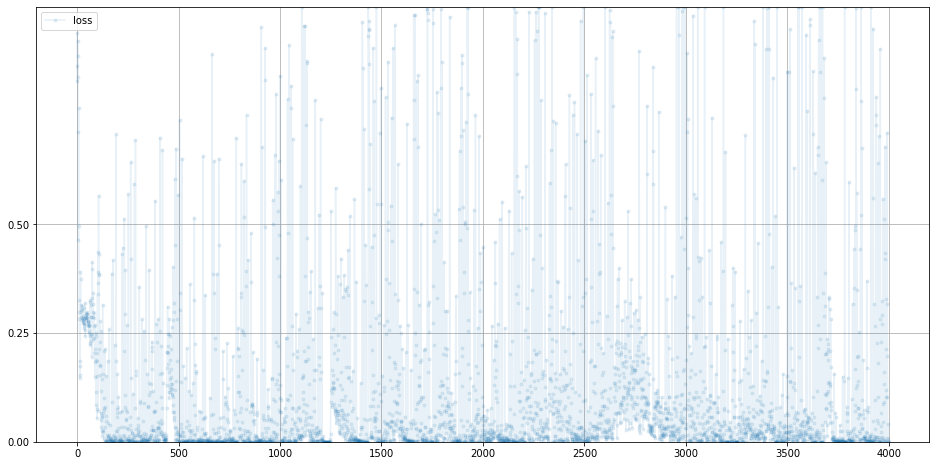

In [55]:
D.plot_progress()

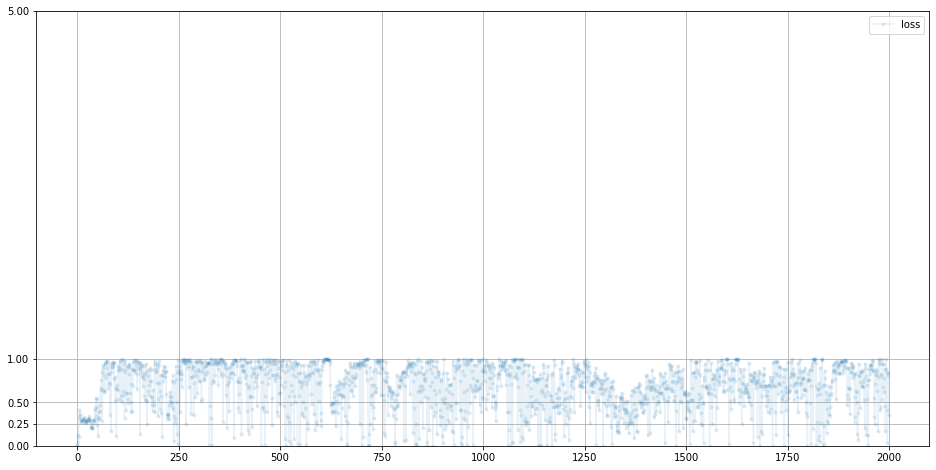

In [56]:
G.plot_progress()

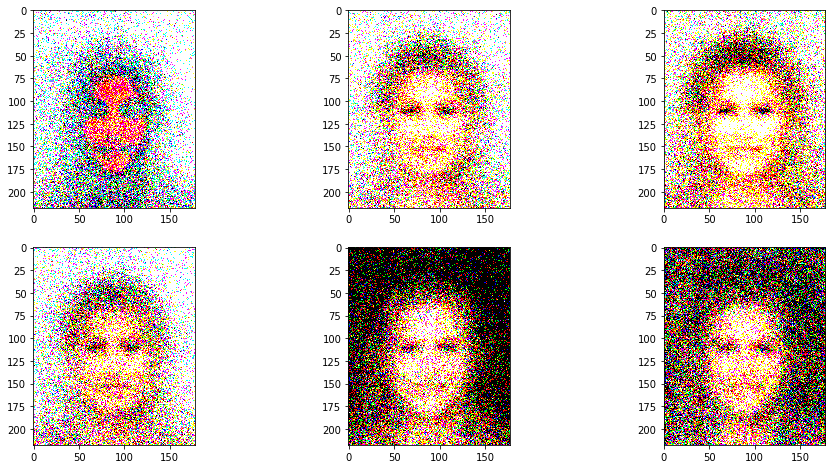

In [58]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.cpu().forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [59]:
%%time

D = Discriminator().cuda(0)
G = Generator().cuda(0)

epochs = 5

for epoch in range(epochs):
    print("epoch = ", epoch + 1)

    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor.cuda(0), torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100).cuda(0)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100).cuda(0), torch.cuda.FloatTensor([1.0]))
        pass
    pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
epoch =  2
counter =  50000
counter =  60000
counter =  70000
counter =  80000
epoch =  3
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
epoch =  5
counter =  170000
counter =  180000
counter =  190000
counter =  200000
Wall time: 1h 37min


In [63]:
import playsound
a = playsound.playsound('../learn_end.mp3')
a

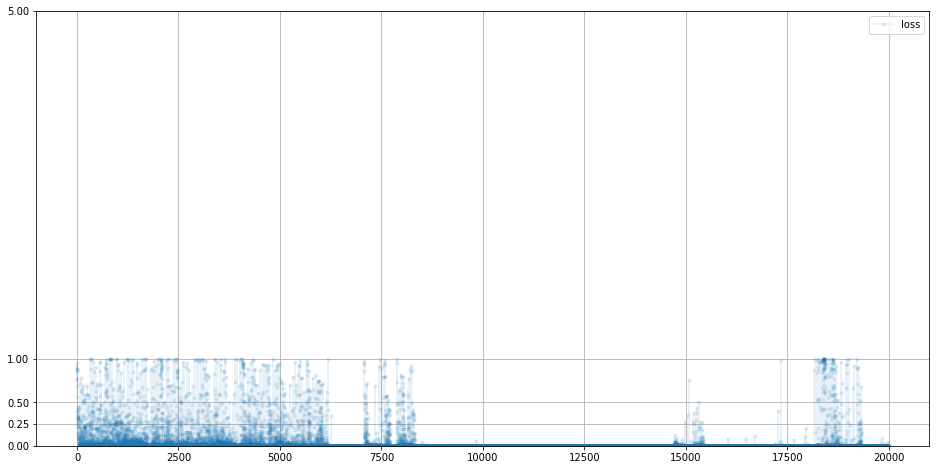

In [64]:
D.plot_progress()

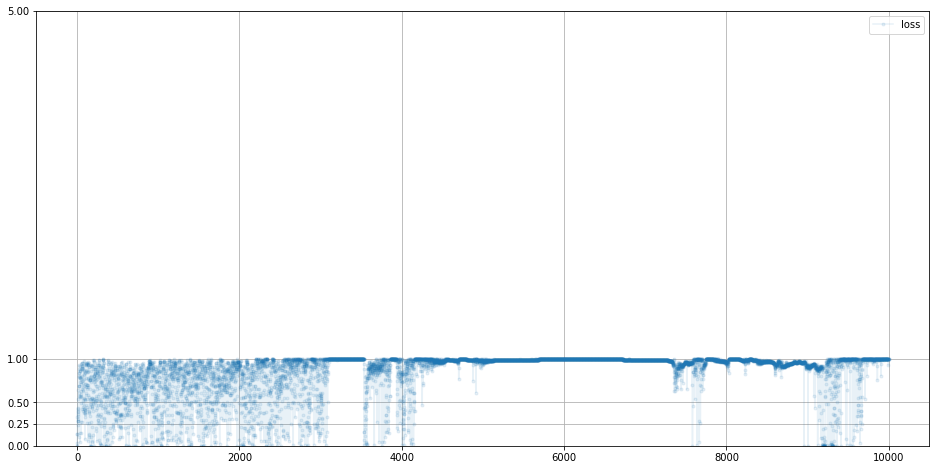

In [65]:
G.plot_progress()

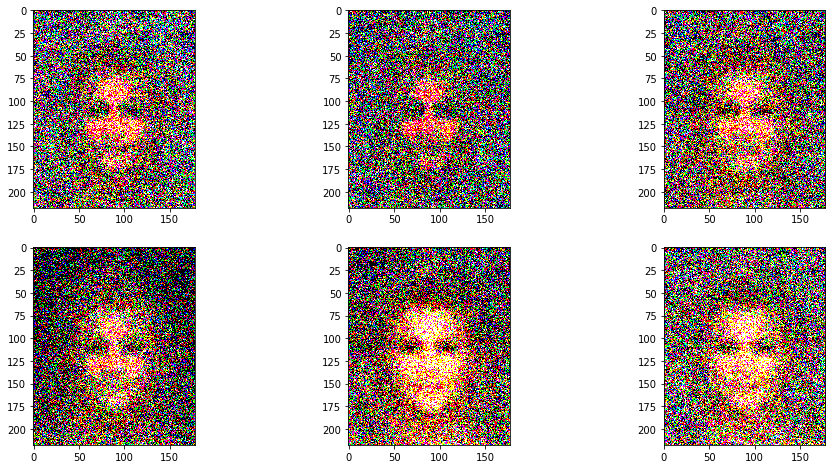

In [66]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.cpu().forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass